# Problema 2: Regresión con datos sintéticos
Iniciamos por importar las bibliotecas usuales y cargar los datos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x_train = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/x_entrenamiento.csv", header=None)
y_train = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/y_entrenamiento.csv", header=None)
x_val = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/x_validacion.csv", header=None)
y_val = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/y_validacion.csv", header=None)

## a. Graficación de los datos
A continuación graficamos los datos por features vs responses en los conjuntos de entrenamiento y validación. Podemos observar algunas irregularidades, principalemente en el conjunto de entrenamiento. En el primer plot podemos observar que hay una franja en la cual no hay valores de x. Es probable que las predicciones no sean buenas para puntos en el conjunto de validación en esa región.

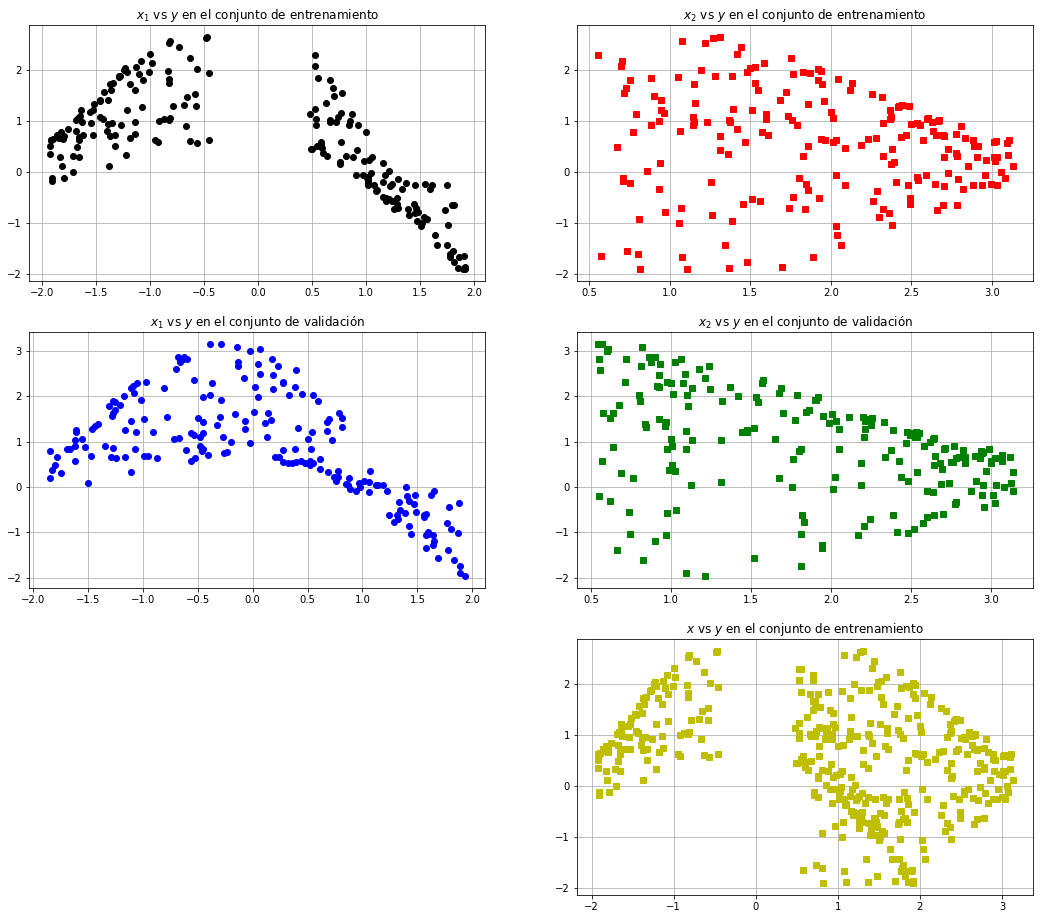

In [55]:
# Graficación de los datos
gs = plt.GridSpec(3,2)
fig = plt.figure(figsize=(18,16))

# Datos de entrenamiento
fig.add_subplot(gs[0,0]).plot(x_train.values[0:,0],y_train.values[0:], 'ko')
plt.grid(True)
plt.title("$x_1$ vs $y$ en el conjunto de entrenamiento")
fig.add_subplot(gs[0,1]).plot(x_train.values[0:,1],y_train.values[0:], 'rs')
plt.title("$x_2$ vs $y$ en el conjunto de entrenamiento")
plt.grid(True)

# Datos de validación
fig.add_subplot(gs[1,0]).plot(x_val.values[0:,0],y_val.values[0:],'bo')
plt.title("$x_1$ vs $y$ en el conjunto de validación")
plt.grid(True)
fig.add_subplot(gs[1,1]).plot(x_val.values[0:,1],y_val.values[0:],'gs')
plt.title("$x_2$ vs $y$ en el conjunto de validación")
plt.grid(True)

fig.add_subplot(gs[2,1]).plot(x_train.values,y_train.values, 'ys')
plt.title("$x$ vs $y$ en el conjunto de entrenamiento")
plt.grid(True)

## b. Regresión lineal 
Ahora aplicamos regresión lineal al problema. En particular tomamos un modelo de la forma $f(x,a) = a_0+a_1x_1+a_2x_2.$ Deseamos entonces hallar $a = (a_0,a_1,a_2)$ que minimize a la función de error
$$E(a)=\frac{1}{2}\sum _{i=0}^N(y_i-f(x^i,a))^2$$

Para entrenar tal regresión usamos nuestra propia implementación de la regresión con funciones base polinómicas, polynomial_linreg(features, responses,d). En general, el número $d$ determina el grado de los polinomios que permitimos como funciones base. Por supuesto, para $d=1$ obtenemos una simple regresión lineal. 

Debajo entrenamos dicho modelo, y reportamos los parámetros obtenidos (por máxima verosimilitud).

In [4]:
# Importamos nuestra implementación de la regresión lineal polinómica; vea polynomialReg.py para los detalles de la implementación. 
from polynomialReg import *

# Entrenamos el modelo con d=1 para tener una regresión lineal
mlinear = polynomial_linreg(x_train.values, y_train.values, 1)
mlinear.fit()

print("Los coeficientes de la regresión son \n a=:", mlinear.a.ravel())

Los coeficientes de la regresión son 
 a=: [ 1.08332958 -0.54618495 -0.30062493]


Ahora reportamos los errores cuadráticos medios del modelo, es decir, 

$$E(a) = \frac{1}{N}\sum_{i=1}^N (y[i]-\langle a, x[i]\rangle)^2$$

In [5]:
print("El error cuadrático medio para el conjunto de entrenamiento es:", mlinear.msqerror(x_train.values,y_train.values))
print("El error cuadrático medio para el conjunto de validación es:", mlinear.msqerror(x_val.values,y_val.values))

El error cuadrático medio para el conjunto de entrenamiento es: 0.7678865214973422
El error cuadrático medio para el conjunto de validación es: 0.9480140975366951


## c) Entrenar un modelo con base polinomial y regularización ridge
Ahora buscamos el mejor modelo de entre aquellos resultantes de variar el grado de los polinomios base y variar el coeficiente de regularización ridge. 

Para este problema usamos la paquetería sklearn.linear_model para aplicar regularización ridge.  El paquete custom_routines se implemento usando solamente numpy. Vea el archivo custom_routines.py para más detalles.

Debajo también generamos un arreglo con veinte valores de $\alpha\in \mathbb R$  tal que su logaritmo está  uniformemente distribuido sobre el intervalo $[-4,2]$.  Es importante mencionar que intentamos con otros rangos de $\alpha$, en particular, valores más pequeños pero comenzaban a aparecer advertencias de inversiones de matrices mal condicionadas. Además, el erro parecía no disminuir rápidamente. 

In [52]:
from sklearn.linear_model import Ridge
from custom_routines import custom_routines as cr

alphas = np.logspace(-4, 2, 20)

Ahora ejecutamos un doble ciclo para encontrar el mejor coeficiente $\alpha$ y mejor grado correspondiente. En esta ocasión los diferentes se comparan simplemente comparando sus sumas de errores cuadráticos  sobre el conjunto de validación (buscando, por supuesto, aquel que mínimize dicha cantidad).  

A partir de ahora, por "error" se debe entender "suma de errores cuadráticos", i.e., la cantidad $$E(a) = \frac{1}{N}\sum_{i=1}^N (y[i]-\langle a, x[i]\rangle)^2.$$

Cabe mencionar que asumimos un modelo sin interacciones entre las variables independientes (es decir, la matriz del modelo no contiene terminos cruzados, cada renglón es simplemente de la forma $(1, x_1, x_1^2,\dots, x_1^d, x_2, x_2^2, \dots ,x_2^d)$. También, a base de exploración determinamos que basta buscar entre los grados 1 hasta 10. Permitir grados más altos no es de ningún beneficio; esto es natural, pues sabemos que entre más grande sea el grado es más probable que caigamos en overfitting.

In [53]:
# Encontrar mejores alpha y grado en 1,...,10, aquellos que minimizan la suma de erroees cuadrǽticos para el conjunto de validación

# Arreglos para guardar los datos de cada ejecución del ciclo.
train_best_param = np.ndarray(shape=(len(alphas),2))
val_best_param = np.ndarray(shape=(len(alphas),2))

train_results = np.zeros(10)
val_results = np.zeros(10)
count = 0

for a in alphas:
    # Preparar regresión ridge con coeficiente de regularización a
    polyRidge = Ridge(alpha = a, fit_intercept =False)
    
    for d in range(0,10):
        # generate matrix model with polynomials of degree d+1
        Xd = cr.modelMatrix(x_train.values, d+1)
    
        # train ridge regression
        polyRidge.fit(Xd, y_train.values)
    
        # calculate error on training set
        train_results[d] = cr.sqerror(polyRidge.predict(Xd), y_train.values)
    
        # calculate error on validation set
        Xd_val = cr.modelMatrix(x_val.values, d+1)
        val_results[d] = cr.sqerror(polyRidge.predict(Xd_val),y_val.values)
        
    # Save best degree for given alpha on training set 
    train_best_param[count][0] = train_results.min()
    train_best_param[count][1] = train_results.argmin() + 1    
    
    # Save best degree for given alpha on validation set   
    val_best_param[count][0] = val_results.min()
    val_best_param[count][1] = val_results.argmin() + 1
    count += 1

In [49]:
# Extraemos alpha y grado buscados
train_alpha_min = train_best_param[0:][0].argmin()
print("Error mínimo en conjunto de entrenamiento:", train_best_param[train_alpha_min][0],  "para alpha ", 
      alphas[train_alpha_min], "y grado ", train_best_param[train_alpha_min][1])

val_alpha_min = val_best_param[0:][0].argmin()
print("Error mínimo en conjunto de validación:", val_best_param[val_alpha_min][0],  "para alpha ", 
      alphas[val_alpha_min], "y grado ", val_best_param[val_alpha_min][1])

Error mínimo en conjunto de entrenamiento: 14.355633887810155 para alpha  2.3357214690901213e-05 y grado  10.0
Error mínimo en conjunto de validación: 26.115380006455517 para alpha  2.3357214690901213e-05 y grado  7.0


Ahora graficamos el comportamiento del error con respecto a variar el coeficiente de regularización $\alpha$.

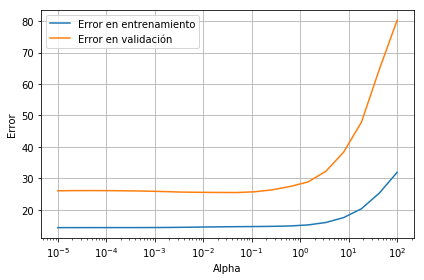

In [50]:
ax = plt.gca()
ax.plot(alphas, train_best_param[0:,0], label = "Error en entrenamiento")
ax.plot(alphas, val_best_param[0:,0], label = "Error en validación")

ax.set_xscale('log')
plt.legend()
plt.grid(True)
plt.ylabel("Error")
plt.xlabel("Alpha")
plt.tight_layout()
plt.show()

Finalmente, como conclusión, presentamos los detalles del mejor modelo encontrado con regresión polinómica con regularización ridge. Recuerde que este se obtuvo con $\alpha =0.00020691380811147902$ y $d = 7$. Note que por lo tanto, ya que hay 2 variables, se tienen $7*2 + 1 =15$ coeficientes en total para la regresión.

In [58]:
# El modelo que minimiza el error en el conjunto de validación
bestmodel = Ridge(alpha=0.00020691380811147902, fit_intercept = False)

# La matriz correspondiente
X7 = cr.modelMatrix(x_train.values,7)
print(len(X7[0]))
X7_val = cr.modelMatrix(x_val.values,7)

# Entrenamiento del modelo
bestmodel.fit(X7, y_train.values)

# Imprimir los detalles del modelo
print("Los 15 coeficientes del mejor modelo son:\n\n", bestmodel.coef_[0])
print("\nEl error sobre el conjunto de entrenamiento es:", cr.sqerror(bestmodel.predict(X7),y_train.values)[0])
print("El error sobre el conjunto de validación es:", cr.sqerror(bestmodel.predict(X7_val),y_val.values)[0])

15
Los 15 coeficientes del mejor modelo son:

 [ 2.17729542 -0.42004545 -1.3055884  -0.7038566   0.46150051  0.43876914
 -0.08351836 -0.07145677  1.56363748 -1.62909738 -4.90124429  9.4709033
 -6.27296025  1.81748355 -0.19486909]

El error sobre el conjunto de entrenamiento es: 15.338568479076782
El error sobre el conjunto de validación es: 26.07111790961768
